# Unitary cost function gradient descent SPT extraction

Created 04/10/2024

Objectives:
* Apply methods from "Unitary cost function gradient descent" notebook to deduce unitaries across a range of states and hence extract SPT phase.

# Package imports

In [2]:
import sys
sys.path.append('../../')

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [160]:
from functools import reduce 

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/0_50.h5"

In [9]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_50.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Load data

In [15]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [16]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [17]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [18]:
psi_dict = dict()

In [19]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [20]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [21]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [22]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [23]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [24]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [48]:
NUM_SITES = 6

## Functions

In [26]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [27]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [28]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [29]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [30]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [31]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [32]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [33]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [34]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [35]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [36]:
def unitarity_gradient(matrix, grouped_physical_leg_label,
                      grouped_physical_leg_conj_label):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())
    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [37]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [101]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(overlap)

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

# Sweep to find unitaries

In [102]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 0.4
num_iterations = 300

In [103]:
matrix_dim = 2**NUM_SITES

In [104]:
len(cases)

21

In [105]:
for i, l in enumerate(cases):
    print(f"case: {i}")

    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())
    solutions.append(list())

    for c in l:
        unitarity_scores[-1].append(list())
        overlap_scores[-1].append(list())
        target_scores[-1].append(list())
        
        sing_val = c.symmetry_transfer_matrix_singular_vals[0]
        target = np.power(sing_val, -1/2)
        
        current_bs = [
            c.psi.get_B(i)
            for i in range(
                test_case.right_symmetry_index + 1,
                test_case.right_symmetry_index + 1 + NUM_SITES
            )
        ]
    
        t = c.right_projected_symmetry_state
        
        for i, b in enumerate(current_bs):
            b_current = b.replace_label('p', f'p{i}')
        
            t = npc.tensordot(t, b_current, [['vR'], ['vL']])
            t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])
        
        t = npc.trace(t, 'vR', 'vR*')
    
        leg_labels = [f'p{i}' for i in range(NUM_SITES)]
        leg_conj_labels = [f'p{i}*' for i in range(NUM_SITES)]
    
        current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])
    
        grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
        grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

        current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)
    
        for _ in range(num_iterations):
            update(
                current_matrix,
                current_grouped_t,
                unitarity_scores[-1][-1],
                overlap_scores[-1][-1],
                target_scores[-1][-1],
                grouped_physical_leg_label,
                grouped_physical_leg_conj_label,
                matrix_dim,
                unitarity_lr=lr,
                overlap_lr=lr,
                target=target
            )

        solutions[-1].append(current_matrix)

case: 0
case: 1
case: 2
case: 3
case: 4
case: 5
case: 6
case: 7
case: 8
case: 9
case: 10
case: 11
case: 12
case: 13
case: 14
case: 15
case: 16
case: 17
case: 18
case: 19
case: 20


# Convergence analysis

## Unitarity

In [106]:
np.array(unitarity_scores)[:,:,-1]

array([[2.78589239e-04, 2.77754584e-04, 2.76087169e-04, 2.77292144e-04],
       [2.76379330e-04, 2.77489055e-04, 2.80010928e-04, 2.79119436e-04],
       [2.76398839e-04, 2.77201649e-04, 2.77695286e-04, 2.76523234e-04],
       [2.79051456e-04, 2.79825497e-04, 2.77870977e-04, 2.83541949e-04],
       [2.85321001e-04, 2.89802233e-04, 2.90092731e-04, 2.89737564e-04],
       [2.96915880e-04, 3.09956509e-04, 3.05148880e-04, 3.19716420e-04],
       [3.35683385e-04, 3.71756156e-04, 3.66910577e-04, 4.14503681e-04],
       [4.48425666e-04, 5.41781074e-04, 5.52323985e-04, 7.33170865e-04],
       [6.31988753e-04, 1.21883571e-03, 1.24420398e-03, 2.15618629e-03],
       [1.28731300e-03, 4.42535370e-03, 4.56483689e-03, 9.99993768e-03],
       [4.42623726e-03,            nan, 1.37777318e-02, 1.45641246e+00],
       [4.79520565e-03, 1.03079757e-02, 1.14477179e-02, 1.78277034e-02],
       [5.85314545e-03, 8.46549605e-03, 8.69010789e-03, 1.21983695e-02],
       [5.53497281e-03, 8.04398076e-03, 7.48071170e

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/4028382766.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


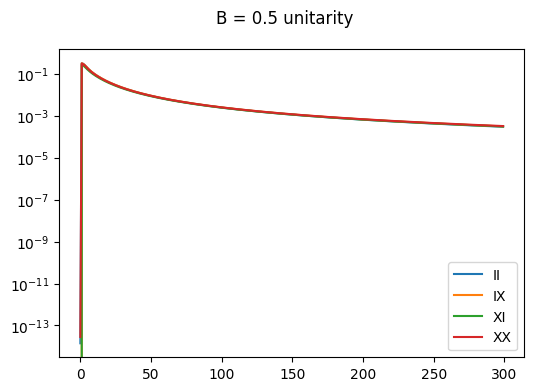

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[5], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/588135298.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


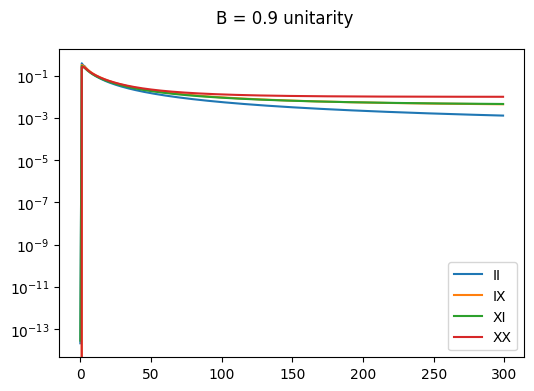

In [108]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[9], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.9 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/3623474513.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


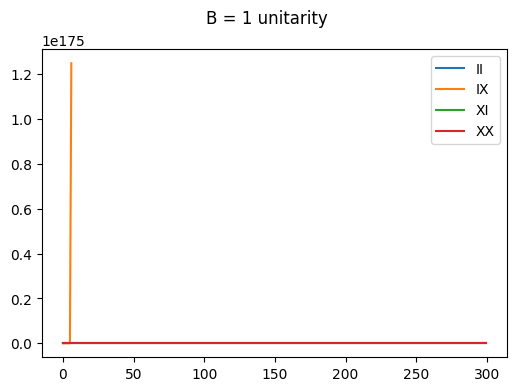

In [109]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[10], symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/983117741.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


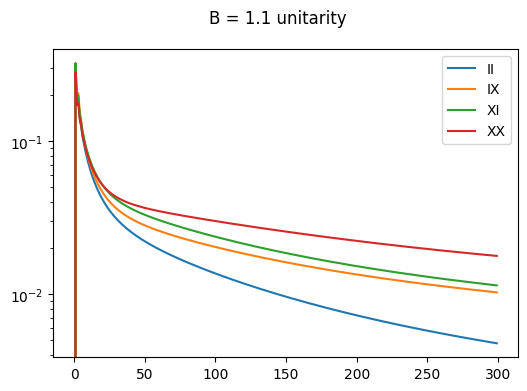

In [110]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[11], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1.1 unitarity')
fig.show()

Generally converging, perhaps needs longer times? Or different learning rates.

## Overlaps

In [112]:
np.abs(np.array(overlap_scores)[:,:,-1])

array([[1.39035925, 1.39039543, 1.39046757, 1.39041534],
       [1.39045612, 1.39040797, 1.39029907, 1.39033753],
       [1.39047251, 1.39043759, 1.39041623, 1.39046683],
       [1.39043837, 1.39040368, 1.39048804, 1.3902423 ],
       [1.39041331, 1.39021374, 1.39020144, 1.39020668],
       [1.39052566, 1.38994704, 1.39014497, 1.38950999],
       [1.39030915, 1.38879068, 1.38897149, 1.38708269],
       [1.38916667, 1.38568812, 1.38536313, 1.37961122],
       [1.39010647, 1.37453339, 1.37400448, 1.3550377 ],
       [1.38875474, 1.34184349, 1.34041745, 1.27945354],
       [1.14204763,        nan, 1.0705388 , 1.427385  ],
       [1.11605392, 1.07224792, 1.06503553, 1.02520163],
       [1.05379878, 1.03375622, 1.03225839, 1.00925804],
       [1.02517793, 1.00646309, 1.01030904, 0.99534808],
       [1.00340781, 0.99794153, 1.00329405, 0.9889401 ],
       [0.99888914, 0.9924998 , 0.99781506, 0.99460507],
       [0.99240823, 0.98807468, 0.99402223, 0.98807971],
       [0.98690614, 0.98738734,

In [113]:
sing_vals = [[c.symmetry_transfer_matrix_singular_vals[0] for c in l] for l in cases]

In [114]:
targets = np.array([[np.power(s, -1/2) for s in l] for l in sing_vals])

In [115]:
np.round(targets - np.abs(np.array(overlap_scores)[:,:,-1]), 3)

array([[0.024, 0.024, 0.024, 0.024],
       [0.024, 0.024, 0.024, 0.024],
       [0.024, 0.024, 0.024, 0.024],
       [0.024, 0.024, 0.024, 0.024],
       [0.024, 0.024, 0.024, 0.024],
       [0.025, 0.025, 0.025, 0.026],
       [0.026, 0.028, 0.027, 0.029],
       [0.03 , 0.033, 0.034, 0.039],
       [0.035, 0.05 , 0.051, 0.07 ],
       [0.047, 0.098, 0.099, 0.164],
       [0.08 ,   nan, 0.151, 7.101],
       [0.083, 0.127, 0.134, 0.174],
       [0.09 , 0.11 , 0.111, 0.134],
       [0.085, 0.104, 0.1  , 0.115],
       [0.085, 0.091, 0.085, 0.1  ],
       [0.074, 0.081, 0.075, 0.079],
       [0.069, 0.074, 0.068, 0.074],
       [0.066, 0.066, 0.064, 0.064],
       [0.057, 0.056, 0.056, 0.056],
       [0.05 , 0.05 , 0.05 , 0.05 ],
       [0.044, 0.043, 0.049, 0.045]])

Generally pretty ok, but could be better.

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/1457258723.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


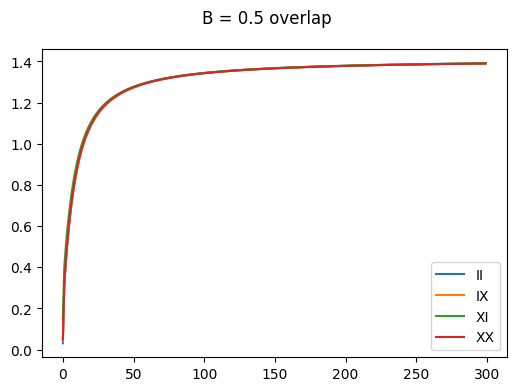

In [116]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[5]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 0.5 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/846040587.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


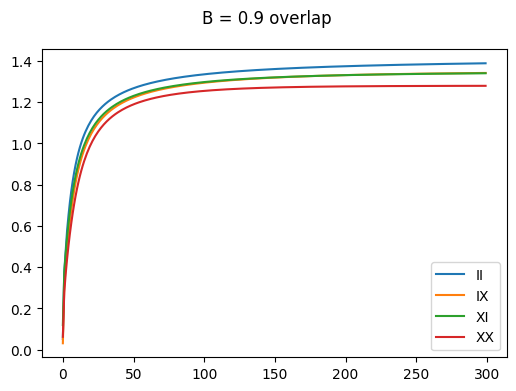

In [117]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[9]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 0.9 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/572593937.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


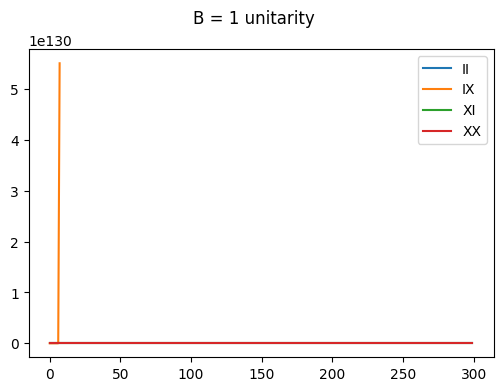

In [118]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[10]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/1450865751.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


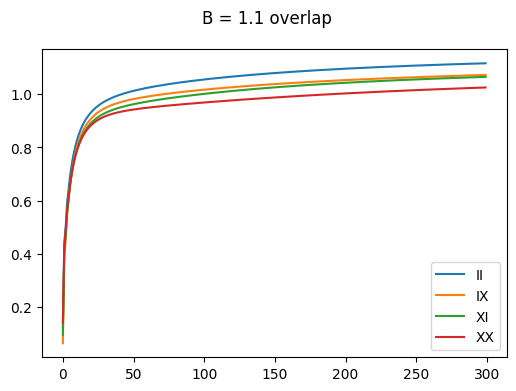

In [119]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[11]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1.1 overlap')
fig.show()

## Target score

In [120]:
np.array(target_scores)[:,:,-1]

array([[1.41664563e-04, 1.41236172e-04, 1.40383155e-04, 1.41000295e-04],
       [1.40531762e-04, 1.41100817e-04, 1.42392380e-04, 1.41935616e-04],
       [1.40542283e-04, 1.40954654e-04, 1.41207416e-04, 1.40608727e-04],
       [1.41893011e-04, 1.42301984e-04, 1.41301179e-04, 1.44222090e-04],
       [1.45035980e-04, 1.47418767e-04, 1.47567564e-04, 1.47481072e-04],
       [1.50696172e-04, 1.57760134e-04, 1.55294037e-04, 1.63175610e-04],
       [1.69551389e-04, 1.89457619e-04, 1.86983965e-04, 2.13167644e-04],
       [2.23643057e-04, 2.77002065e-04, 2.82416496e-04, 3.84661977e-04],
       [3.05363206e-04, 6.29497010e-04, 6.42748072e-04, 1.19237926e-03],
       [5.76869011e-04, 2.35472844e-03, 2.42480915e-03, 6.36022650e-03],
       [1.71680169e-03,            nan, 5.95776102e-03, 1.02309335e+01],
       [1.86670184e-03, 4.26107398e-03, 4.75209536e-03, 7.84732680e-03],
       [2.19491847e-03, 3.25570763e-03, 3.34437419e-03, 4.82452977e-03],
       [2.00529867e-03, 2.96404890e-03, 2.75082021e

These are all quite good. But the cost functions are quartic for unitaries and quadratic for the overlap. So it makes sense these are much smaller. Perhaps should renormalise somehow...?

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/2222439871.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


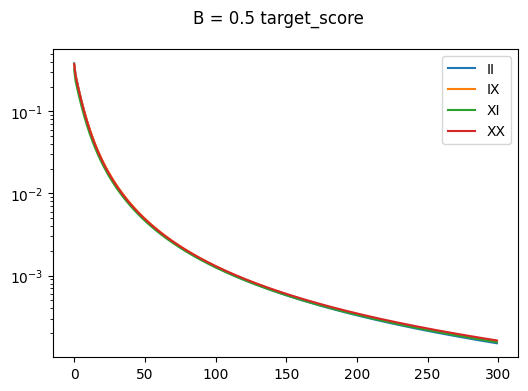

In [121]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[5], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 target_score')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/1728333252.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


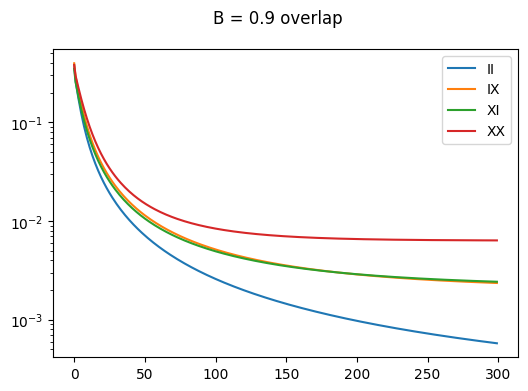

In [122]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[9], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.9 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/2192447709.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


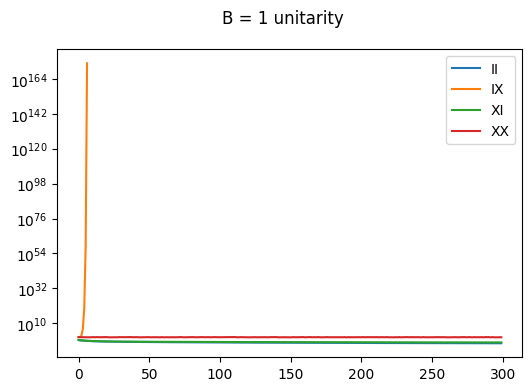

In [123]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[10], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/3726596553.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


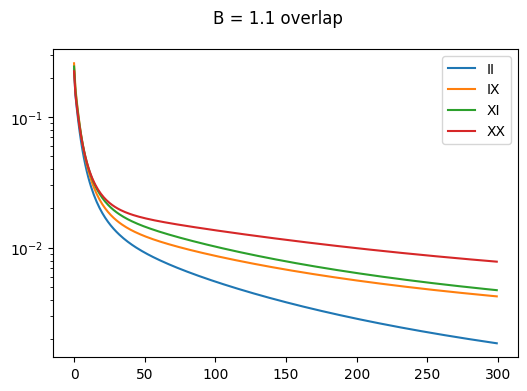

In [124]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[11], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1.1 overlap')
fig.show()

## Comparison with exact solution

Compute exact solutions

In [125]:
exact_solutions = list()
exact_overlaps = list()

In [126]:
for i, l in enumerate(cases):
    print(f"case {i}")

    exact_solutions.append(list())
    exact_overlaps.append(list())

    for c in l:
        current_bs = [
            c.psi.get_B(i)
            for i in range(
                test_case.right_symmetry_index + 1,
                test_case.right_symmetry_index + 1 + NUM_SITES
            )
        ]
    
        t = c.right_projected_symmetry_state
        
        for i, b in enumerate(current_bs):
            b_current = b.replace_label('p', f'p{i}')
        
            t = npc.tensordot(t, b_current, [['vR'], ['vL']])
            t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])
        
        t = npc.trace(t, 'vR', 'vR*')
    
        leg_labels = [f'p{i}' for i in range(NUM_SITES)]
        leg_conj_labels = [f'p{i}*' for i in range(NUM_SITES)]
    
        current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])
    
        grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
        grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

        U, S, VH = npc.svd(current_grouped_t.conj(), full_matrices=True, inner_labels=['i', 'i*'])
        sol = npc.tensordot(U, VH, [['i',], ['i*',]])
        score = np.sum(S)

        exact_solutions[-1].append(sol)
        exact_overlaps[-1].append(score)

case 0
case 1
case 2
case 3
case 4
case 5
case 6
case 7
case 8
case 9
case 10
case 11
case 12
case 13
case 14
case 15
case 16
case 17
case 18
case 19
case 20


In [138]:
solution_differences = list()

for l1, l2, lo in zip(solutions, exact_solutions, overlap_scores):
    solution_differences.append(list())
    
    for approx, exact, overlaps in zip(l1, l2, lo):
        overlap = overlaps[-1]
        real_approx = approx*(overlap.conj()/np.abs(overlap))

        X = (real_approx - exact).to_ndarray()
        diff_score = np.linalg.norm(X)
        solution_differences[-1].append(diff_score)

solution_differences = np.array(solution_differences)

In [139]:
solution_differences

array([[10.97180765, 10.96850761, 11.03937717, 10.95878118],
       [10.93868537, 10.93733175, 10.99982044, 10.88384419],
       [11.11269706, 10.85486603, 10.90627613, 10.93389839],
       [10.93429039, 10.97150469, 11.05208997, 10.95161562],
       [10.98261906, 11.01963938, 10.98326481, 10.78815152],
       [11.05399425, 10.97938769, 10.90950117, 10.97243229],
       [10.88464197, 11.05132662, 10.75444162, 10.84318934],
       [10.84068273, 11.00226719, 10.87489302, 10.9340229 ],
       [10.8985477 , 10.95678465, 10.88430254, 11.04309889],
       [11.04375412, 10.97803728, 10.95800324, 10.89528975],
       [11.05656022,         nan, 11.02415075, 10.92355867],
       [10.95622948, 11.00991861, 11.0571955 , 10.86913102],
       [10.88718464, 11.09655871, 11.03864457, 11.12162086],
       [11.01113294, 11.1153253 , 11.0873882 , 11.00982715],
       [11.15002428, 11.15788523, 11.05837419, 11.20183519],
       [11.03125019, 11.17092918, 11.25846198, 11.08297988],
       [11.25647618, 11.

A frobenius norm of 10 implies that the average squared difference is about $10^2/2^12 \approx 1/40 = 0.025$, which gives a rough average difference of $1/6\approx 0.15$.

In [152]:
solution_differences_1 = list()

for l1, l2, lo in zip(solutions, exact_solutions, overlap_scores):
    solution_differences_1.append(list())
    
    for approx, exact, overlaps in zip(l1, l2, lo):
        overlap = overlaps[-1]
        real_approx = approx*(overlap.conj()/np.abs(overlap))

        X = (real_approx - exact).to_ndarray()
        diff_score = np.max(np.abs(X))
        solution_differences_1[-1].append(diff_score)

solution_differences_1 = np.array(solution_differences_1)

In [153]:
solution_differences_1

array([[0.6637916 , 0.66276242, 0.61277086, 0.65395893],
       [0.90630719, 0.891261  , 0.91519771, 0.94754759],
       [1.165427  , 1.09193588, 1.08621468, 1.03289805],
       [1.09845588, 1.08298468, 1.14291718, 1.027654  ],
       [1.16869326, 1.13617172, 1.15420278, 1.07914945],
       [1.1345899 , 1.14371697, 1.11737374, 1.15926115],
       [1.16424257, 1.09489634, 1.0830001 , 1.21875478],
       [1.1127048 , 1.14900194, 1.06887291, 1.0928615 ],
       [1.11065926, 1.07650565, 1.07564322, 1.15361908],
       [1.14296543, 1.08958938, 1.05291641, 0.97232863],
       [1.12512966,        nan, 0.58321626, 0.73762339],
       [1.08626472, 0.54355159, 0.60554904, 0.61246642],
       [1.08386085, 0.63897001, 0.68396129, 0.69774787],
       [1.14012938, 0.72034514, 0.61762549, 0.65040947],
       [1.18912684, 0.6439865 , 0.64740125, 0.58974506],
       [1.21518181, 0.6753403 , 0.63967768, 0.5534733 ],
       [1.1663876 , 0.59456793, 0.67502753, 0.56692538],
       [1.07943281, 0.68069893,

And the phase of the approximation does not appear to be making much of a difference...

In [156]:
np.array(exact_overlaps) - np.abs(np.array(overlap_scores)[...,-1])

array([[ 0.02385431,  0.02381814,  0.02374599,  0.02379822],
       [ 0.02375856,  0.02380663,  0.02391553,  0.02387699],
       [ 0.02375946,  0.02378904,  0.0238104 ,  0.02375447],
       [ 0.0238734 ,  0.02384545,  0.02376109,  0.02394419],
       [ 0.02413544,  0.02396707,  0.02397937,  0.02360629],
       [ 0.02459721,  0.02368304,  0.02348511,  0.02262887],
       [ 0.02607518,  0.0227462 ,  0.0225654 ,  0.01962332],
       [ 0.02989987,  0.01966587,  0.01999084,  0.01216271],
       [ 0.03479686,  0.01441321,  0.01493047, -0.00115213],
       [ 0.04733531,  0.00500568,  0.00291799, -0.01986462],
       [ 0.0798828 ,         nan,  0.02077959, -0.22580044],
       [ 0.0833639 ,  0.05643706,  0.06320387,  0.03646228],
       [ 0.08971076,  0.07508131,  0.07657904,  0.06594541],
       [ 0.08519981,  0.08508159,  0.08123561,  0.07767823],
       [ 0.08514722,  0.07960364,  0.0742511 ,  0.07770474],
       [ 0.07426549,  0.07385487,  0.06853959,  0.06499195],
       [ 0.06933837,  0.

Calculated overlap quite close to exact value however. Still some room for improvement though. Maybe some tension between the unitarity and overlap gradients? Close to the optimum they should be almost directly opposed.

# Extract SPT phase

In [157]:
from itertools import combinations

In [158]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [159]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [161]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [174]:
def distance_from_identity(j, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    # Assumes two dimensions

    p1 = grouped_physical_leg_label
    p2 = grouped_physical_leg_conj_label
    e1 = npc.tensordot(j, j.conj(), [[p1, p2], [p2, p1]])

    e2 = npc.trace(j, p1, p2)

    return e1 - 2*e2.real + dim

In [172]:
def gauge_invariant_phase(u1, u2, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    u = reduce(multiply, [u1, u2, u1.conj(), u2.conj()])

    trace = npc.trace(
        u,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    approx_identity = u/phase
    approx_identity_distance = distance_from_identity(
        approx_identity,
        dim,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    return phase, approx_identity_distance

In [175]:
phase_distance_pairs = [
    [
        gauge_invariant_phase(
            *p,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in combinations(l, 2)
    ]
    for l in solutions
]

In [176]:
phases = [[p[0] for p in l] for l in phase_distance_pairs]
distances = [[p[1] for p in l] for l in phase_distance_pairs]

## Phases

In [177]:
len(phases)

21

In [179]:
np.round(phases[:10], 3)

array([[ 0.999-0.039j,  0.906-0.422j,  1.   +0.006j, -0.998-0.055j,
        -1.   -0.002j, -0.998+0.063j],
       [ 0.955+0.295j,  1.   -0.008j,  0.993-0.116j, -0.997+0.075j,
        -0.984+0.176j, -0.965+0.262j],
       [ 1.   -0.014j,  0.973+0.231j,  1.   +0.019j, -1.   +0.023j,
        -0.992-0.129j, -0.957+0.29j ],
       [ 1.   +0.027j,  0.998+0.056j,  0.976+0.216j, -0.989-0.151j,
        -0.977-0.214j, -1.   +0.001j],
       [ 0.99 +0.144j,  0.991+0.136j,  0.997+0.082j, -0.955+0.296j,
        -0.95 +0.312j, -1.   +0.02j ],
       [ 0.998+0.07j ,  0.926+0.377j,  0.998-0.065j, -0.984-0.18j ,
        -0.996+0.085j, -0.997+0.076j],
       [ 0.996+0.093j,  0.975-0.223j,  0.944+0.331j, -0.996-0.093j,
        -0.995+0.1j  , -0.998-0.065j],
       [ 0.977+0.213j,  0.992-0.127j,  0.987+0.159j, -1.   +0.002j,
        -0.999-0.033j, -1.   +0.013j],
       [ 0.879-0.477j,  0.977+0.214j,  0.991-0.133j, -1.   -0.023j,
        -0.99 -0.138j, -0.984-0.178j],
       [ 0.998-0.07j ,  0.989-0.147j,

In [180]:
phases[10]

[(nan+nanj),
 (0.9989743962359048+0.045278644691614474j),
 (0.9984188547355423+0.056212013916670855j),
 (nan+nanj),
 (nan+nanj),
 (-0.9929690144802868-0.11837455926865402j)]

In [182]:
np.round(phases[11:], 3)

array([[ 0.999+0.054j,  0.999+0.048j,  0.882-0.472j,  0.999-0.051j,
         0.996+0.087j,  0.975+0.222j],
       [ 0.871+0.491j,  0.999-0.034j,  0.992-0.123j, -0.802-0.598j,
         0.691-0.723j,  0.393-0.919j],
       [ 0.826+0.564j,  1.   +0.028j,  0.605-0.796j,  0.918+0.395j,
         0.331-0.944j,  0.98 +0.197j],
       [ 1.   +0.023j,  0.901+0.435j,  0.406+0.914j, -0.937+0.351j,
         0.418+0.909j,  0.971+0.237j],
       [ 0.944+0.329j,  0.596+0.803j, -0.763+0.646j,  0.874+0.486j,
         0.722-0.691j,  0.487+0.873j],
       [ 0.84 +0.543j,  0.985+0.171j,  0.796+0.605j, -0.712+0.702j,
         0.996+0.085j,  0.713+0.701j],
       [ 0.997-0.076j,  0.028-1.j   ,  0.599-0.801j,  1.   +0.01j ,
         0.606+0.796j,  0.709-0.705j],
       [ 0.975+0.224j,  0.881-0.474j,  0.949-0.314j,  0.91 +0.414j,
         0.988-0.152j,  0.711+0.703j],
       [ 0.902+0.431j,  0.812+0.584j,  0.997+0.083j,  0.957+0.291j,
         0.941+0.339j,  0.945-0.328j],
       [ 0.529-0.848j,  0.993-0.117j,

Phases are definitely far from clean. Roughly correct. Correct if one ignores imaginary parts and just considers the sign of the real part. But does not look clean enough.

## Distances

In [190]:
distances_array = np.array(distances).T

In [191]:
np.max(distances_array)

(nan+nanj)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


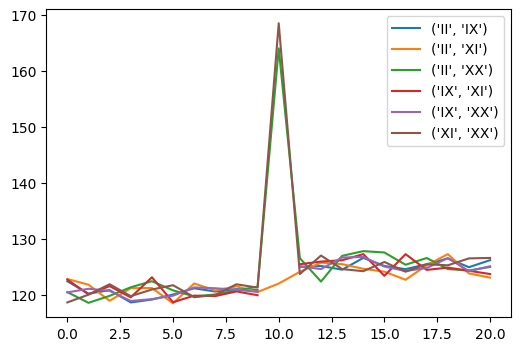

In [192]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

Not good!

# Extract SPT phase from exact solutions

In [194]:
phase_distance_pairs = [
    [
        gauge_invariant_phase(
            *p,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in combinations(l, 2)
    ]
    for l in exact_solutions
]

In [195]:
phases = [[p[0] for p in l] for l in phase_distance_pairs]
distances = [[p[1] for p in l] for l in phase_distance_pairs]

## Phases

In [196]:
len(phases)

21

In [197]:
np.round(phases[:10], 3)

array([[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j]])

In [198]:
phases[10]

[(1+0j), (1+0j), (1+0j), (1+0j), (-0.9999999999999999+0j), (-1+0j)]

In [199]:
np.round(phases[11:], 3)

array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]])

Phases are definitely far from clean. Roughly correct. Correct if one ignores imaginary parts and just considers the sign of the real part. But does not look clean enough.

## Distances

In [200]:
distances_array = np.array(distances).T

In [201]:
np.max(distances_array)

(124.66945748499114+0j)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_60693/3176477689.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


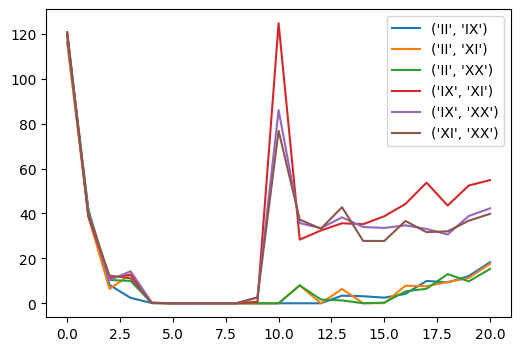

In [202]:
fig, ax = plt.subplots(figsize=(6,4))

for i, x in enumerate(distances_array):
    ax.plot(x, label=symmetry_combination_labels[i])

ax.legend()

fig.show()

Something wrong with my distance calculation? This should be 0...

Step through:

In [204]:
u1, u2 = exact_solutions[0][:2]

In [205]:
def multiply(m1, m2):
    return multiply_tenpy_matrices(
        m1,
        m2,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

In [206]:
u = reduce(multiply, [u1, u2, u1.conj(), u2.conj()])

In [208]:
u.to_ndarray()

array([[ 0.06567712+0.j, -0.15324119+0.j,  0.11793871+0.j, ...,
         0.10141986+0.j,  0.01056597+0.j, -0.1402374 +0.j],
       [-0.25000863+0.j, -0.10474676+0.j, -0.02249893+0.j, ...,
         0.10102712+0.j,  0.17969871+0.j,  0.12794275+0.j],
       [-0.28170006+0.j,  0.08010268+0.j,  0.04724939+0.j, ...,
        -0.28978692+0.j,  0.06738665+0.j,  0.17606465+0.j],
       ...,
       [-0.00127148+0.j, -0.10969562+0.j, -0.14913379+0.j, ...,
         0.23925416+0.j,  0.01345421+0.j,  0.21152848+0.j],
       [-0.0830191 +0.j,  0.1048352 +0.j, -0.07734427+0.j, ...,
         0.04625488+0.j, -0.10742285+0.j,  0.07434062+0.j],
       [-0.08130303+0.j,  0.14647427+0.j,  0.1729908 +0.j, ...,
         0.19010622+0.j, -0.07163866+0.j,  0.09266736+0.j]])

Wait, does the exact solution on more than two sites _not_ give a projective representation...?

TO-DO: Investigate this further!

# Conclusions

* Problem with convergence close to optima, unitarity and overlap gradients cancelling each other out?
* Convergence is working, but not producing clean projective representation.

# Old code

## Test on scalars

In [77]:
scalar = 2*1j

In [78]:
scalar_rdm = npc.Array.from_ndarray_trivial(np.array([[scalar]]), labels=['p', 'p*'])

In [79]:
scalar_rdm

<npc.Array shape=(1, 1) labels=['p', 'p*']>

In [80]:
scalar_matrix = npc.Array.from_ndarray_trivial(np.array([[1.5]]), labels=['p', 'p*'])

In [81]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
target = np.abs(scalar)
matrix_dim = 1
scalar_matrix_values = [scalar_matrix[0,0],]

In [82]:
unitarity_lr = 0.01
overlap_lr = 0.01

In [83]:
update(
    scalar_matrix,
    scalar_rdm,
    unitarity_scores,
    overlap_scores,
    target_scores,
    'p',
    'p*',
    matrix_dim,
    unitarity_lr=unitarity_lr,
    overlap_lr=overlap_lr,
    target=target
)

scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

In [84]:
unitarity_scores

[1.5625]

In [85]:
overlap_scores

[3.0]

In [86]:
for _ in range(100):
    update(
        scalar_matrix,
        scalar_rdm,
        unitarity_scores,
        overlap_scores,
        target_scores,
        'p',
        'p*',
        matrix_dim,
        unitarity_lr=unitarity_lr,
        overlap_lr=overlap_lr,
        target=target
    )

    scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

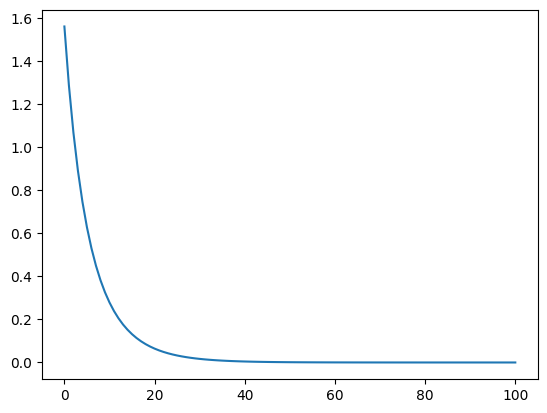

In [87]:
plt.plot(unitarity_scores)

In [88]:
unitarity_scores[-1]

2.5438619757345293e-06

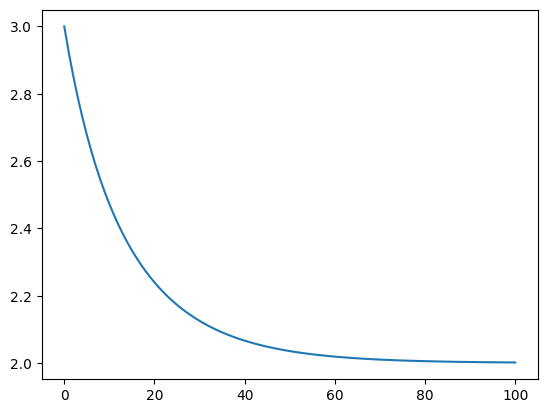

In [89]:
plt.plot(overlap_scores)

In [90]:
overlap_scores[-1]

2.001594313435545

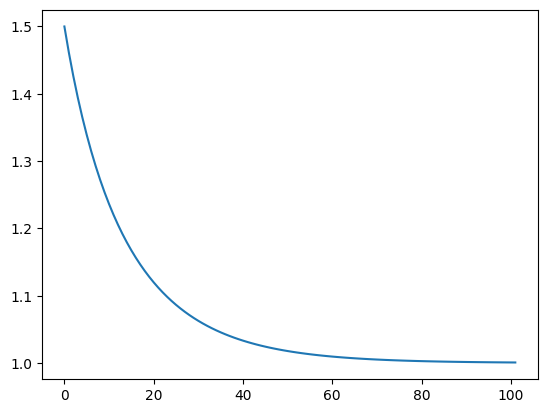

In [91]:
plt.plot(scalar_matrix_values)

In [92]:
scalar_matrix.to_ndarray()

array([[1.00074931+0.j]])

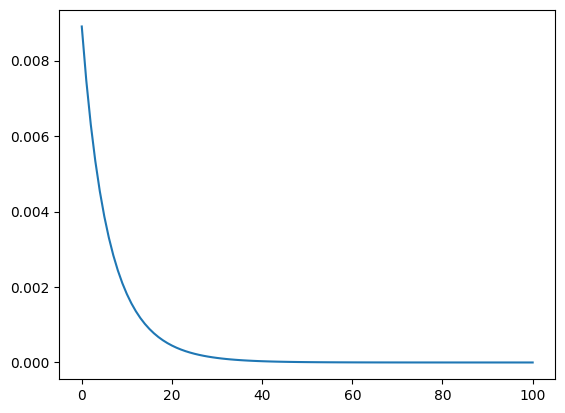

In [93]:
plt.plot(target_scores)